In [2]:
using BenchmarkTools
using Unrolled

using SIMD

using ChipSort



┌ Info: Recompiling stale cache file /home/user/.julia/compiled/v1.2/Unrolled/BnVLg.ji for Unrolled [9602ed7d-8fef-5bc8-8597-8f21381861e8]
└ @ Base loading.jl:1187


In [3]:
sort_small_array(chunk::NTuple{L, Vec{N,T}}) where {L,N,T} =
    merge_vecs(transpose_vecs(sort_net(chunk...)...)...)

function sort_chunks(output, data::Array{T, 1}, ::Val{L}, ::Val{N}) where {L,N,T}
    chunk_size = N*L
    num_chunks = div(length(data), chunk_size)

    for m in 1:num_chunks
        chunk = ntuple(l->vload(Vec{N, T}, data, 1 + (m-1)*chunk_size + (l-1)*N), L)
        sorted_chunk = sort_small_array(chunk)
        vstorent(sorted_chunk, output, 1 + (m-1)*(N*L))
    end
    output
end

function chipsort_st1(data::Array{T, 1}, ::Val{N}, ::Val{L}) where {T, N, L, N2}
    chunk_size = L * N
    Nchunks = div(size(data, 1), chunk_size)
    output1 = valloc(T, div(32, sizeof(T)), length(data))
    sort_chunks(output1, data, Val(L), Val(N))
    output1
end

function sort_chunks_ref(output, data::Array{T, 1}, ::Val{L}, ::Val{N}) where {L,N,T}
    chunk_size = N*L
    num_chunks = div(length(data), chunk_size)

    for m in 1:num_chunks
        output[1 + (m-1)*chunk_size:(m)*chunk_size] = sort(data[1 + (m-1)*chunk_size:(m)*chunk_size])
    end
    output
end

function sort_st1(data::Array{T, 1}, ::Val{N}, ::Val{L}) where {T, N, L, N2}
    chunk_size = L * N

    Nchunks = div(size(data, 1), chunk_size)
    output1 = valloc(T, div(32, sizeof(T)), length(data))
    sort_chunks_ref(output1, data, Val(L), Val(N))
    output1
end

sort_st1 (generic function with 1 method)

In [4]:
function run_bench_mine(T, data_size, ::Val{N}, ::Val{L}) where {N, L}
    data = rand(T, data_size)

    stat = @benchmark chipsort_st1($data, Val($N), Val($L))
    stat
end

function run_bench_base(T, data_size, ::Val{N}, ::Val{L}) where {N, L}
    data = rand(T, data_size)

    stat = @benchmark sort_st1($data, Val($N), Val($L))
    stat
end

function run_test(T, data_size, ::Val{N}, ::Val{L}) where {N, L}
    data = rand(T, data_size)

    chip = chipsort_st1(data, Val(N), Val(L))
    ref = sort_st1(data, Val(N), Val(L))
    display(reshape(chip, N*L,:))
    display(reshape(ref, N*L,:))

    @assert chip==ref
end

run_test (generic function with 1 method)

In [5]:
N = Val(4)

struct ExpRun
    code
    eltype
    data_size
    vec_size
    vec_count
    bench
end

function Base.show(io::IO, ee::ExpRun)
    print(ee.code, " ")
    print(ee.eltype, " ")
    print(ee.data_size, " ")
    print(ee.vec_size, " ")
    print(ee.vec_count, " ")
    print(ee.bench.times[div(end,2)])
end

@unroll function run_tests(nn,ll)
    exps = ExpRun[]

    T = Float32
    data_size = 2^14
    @unroll for n in nn
        @unroll for l in ll
            tt = run_bench_mine(T, data_size, Val(n), Val(l))
            ee = ExpRun(:chip, T, data_size, n, l, tt)
            println(ee)
            push!(exps, ee)
            tt = run_bench_base(T, data_size, Val(n), Val(l))
            ee = ExpRun(:juli, T, data_size, n, l, tt)
            println(ee)
            push!(exps, ee)
        end
    end
    exps
end

data = run_tests((4,8), (4,8,16,32))


chip Float32 16384 4 4 91966.0
juli Float32 16384 4 4 289454.0
chip Float32 16384 4 8 67559.0
juli Float32 16384 4 8 356247.0
chip Float32 16384 4 16 270709.0
juli Float32 16384 4 16 451288.0
chip Float32 16384 4 32 901826.0
juli Float32 16384 4 32 459294.0
chip Float32 16384 8 4 68592.0
juli Float32 16384 8 4 354773.0
chip Float32 16384 8 8 58925.0
juli Float32 16384 8 8 403563.0
chip Float32 16384 8 16 718598.0
juli Float32 16384 8 16 460259.0
chip Float32 16384 8 32 1.240231e6
juli Float32 16384 8 32 516610.0
chip 

16-element Array{ExpRun,1}:
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

Float32 16384 4 4 91966.0juli Float32 16384 4 4 289454.0chip Float32 16384 4 8 67559.0juli Float32 16384 4 8 356247.0chip Float32 16384 4 16 270709.0juli Float32 16384 4 16 451288.0chip Float32 16384 4 32 901826.0juli Float32 16384 4 32 459294.0chip Float32 16384 8 4 68592.0juli Float32 16384 8 4 354773.0chip Float32 16384 8 8 58925.0juli Float32 16384 8 8 403563.0chip Float32 16384 8 16 718598.0juli Float32 16384 8 16 460259.0chip Float32 16384 8 32 1.240231e6juli Float32 16384 8 32 516610.0chip Float32 16384 4 4 91966.0chip Float32 16384 4 4 91966.0juli Float32 16384 4 4 289454.0juli Float32 16384 4 4 289454.0chip Float32 16384 4 8 67559.0chip Float32 16384 4 8 67559.0juli Float32 16384 4 8 356247.0juli Float32 16384 4 8 356247.0chip Float32 16384 4 16 270709.0chip Float32 16384 4 16 270709.0juli Float32 16384 4 16 451288.0juli Float32 16384 4 16 451288.0chip Float32 16384 4 32 901826.0chip Float32 16384 4 32 901826.0juli Float32 16384 4 32 459294.0juli Float32 16384 4 32 459294.0chi

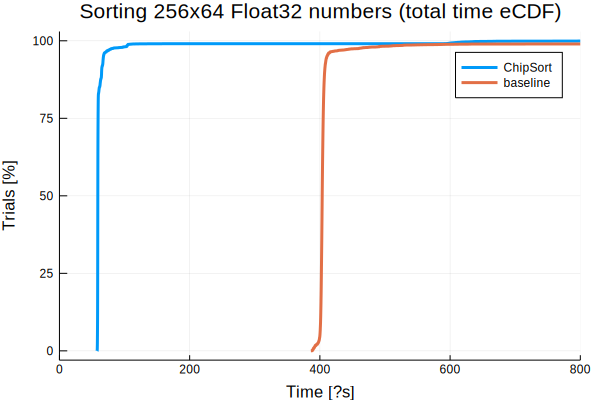

In [6]:
plot(xlim=(0, 800),
     xlabel="Time [μs]", ylabel="Trials [%]", title="Sorting 256x64 Float32 numbers (total time eCDF)")
plot!(data[11].bench.times*1e-3, 1e-2.*(1:10000), l=3, label="ChipSort")
plot!(data[12].bench.times*1e-3, 1e-2.*(1:10000), l=3, label="baseline")



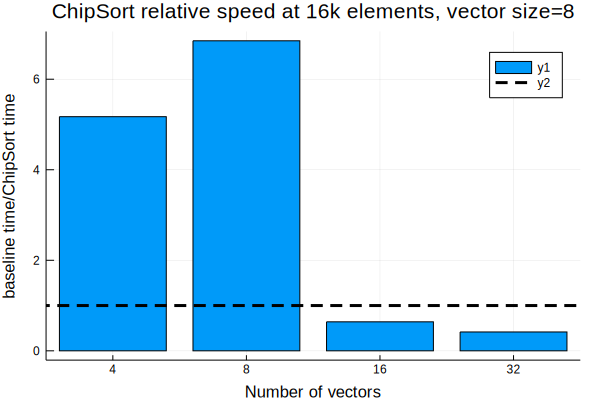

In [7]:
ch = [ee.bench.times[div(end,2)] for ee in data if ee.vec_size == 8 && ee.code==:chip]
jj = [ee.bench.times[div(end,2)] for ee in data if ee.vec_size == 8 && ee.code==:juli]

plot(xticks=(1:4, [4,8,16,32]), title="ChipSort relative speed at 16k elements, vector size=8", xlabel="Number of vectors",
     xlim=(0.5,4.5), ylabel=("baseline time/ChipSort time"))
bar!(jj./ch)
plot!([0,5],[1,1],ls=:dash, color=:black, l=3)